<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº3: Análisis de Fourier: FFT, desparramo, interpolación y ventaneo.
#### Nombre y Apellido: Matías Galperin

# Introducción Teórica
La DFT de 𝑁 puntos de una señal 𝑥[𝑛] (ventana rectangular) se define como:
\begin{equation}
X[k] = \sum_{n=0}^{N-1} x[n],e^{-j2\pi kn/N},\qquad k=0,\dots,N-1.
\end{equation}

La identidad de Parseval (con esta convención) dice:
\begin{equation}
\sum_{n=0}^{N-1} |x[n]|^2 ;=; \frac{1}{N}\sum_{k=0}^{N-1} |X[k]|^2.
\end{equation}

Si definimos el periodograma (PSD discreta) como
\begin{equation}
P[k] ;=; \frac{1}{N},|X[k]|^2,
\end{equation}
entonces
\begin{equation}
\frac{1}{N}\sum_{k=0}^{N-1} P[k] ;=; \frac{1}{N^2}\sum_{k=0}^{N-1}|X[k]|^2 ;=; \frac{1}{N}\sum_{n=0}^{N-1}|x[n]|^2,
\end{equation}
o sea, el promedio de 𝑃[𝑘] (dividiendo por 𝑁) coincide con la potencia promedio de 𝑥[𝑛].

Una senoidal de amplitud 𝐴 y media nula tiene potencia 𝐴^2/2. Para fijar potencia unitaria, usaremos 𝐴=2^1/2.

# Análisis y Desarrollo
Se analizó el efecto del desparramo espectral (leakage) en el cálculo de la densidad espectral de potencia (PSD) mediante la Transformada Discreta de Fourier (DFT).

Primero se generaron tres señales senoidales de potencia unitaria (amplitud √2), de longitud N=100 y frecuencia de muestreo fs=50 kHz, con frecuencias:

- Caso 1: k_0 = N/4 → f_0 = 12.5 kHz
- Caso 2: k_0 = N/4 + 0.25 → f_0 = 12.625 kHz
- Caso 3: k_0 = N/4 + 0.5 → f_0 = 12.750 kHz

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def generar_senoidal(f0, fs, N, A, fase):
    n = np.arange(N)
    x = A * np.sin(2*np.pi*f0*n/fs + fase)
    return n, x

def calcular_psd(x, fs):
    """
    Calcula la PSD con unidades físicas (V^2/Hz) y apta para Parseval.
    """
    N = len(x)
    X = np.fft.fft(x, n=N)
    Pxx = (1/(fs*N)) * np.abs(X)**2  # PSD densa, no normalizada al pico
    f = np.fft.fftfreq(N, d=1/fs)
    return f, Pxx

def psd_dB_pico0(Pxx, eps=1e-20):
    """Normaliza al pico = 0 dB (solo para graficar)"""
    return 10 * np.log10((Pxx + eps) / (Pxx.max() + eps))

def potencia_tiempo(x):
    """Potencia promedio en tiempo"""
    return np.mean(np.abs(x)**2)

def potencia_frecuencia(Pxx):
    """Promedio de la PSD con normalización"""
    Nloc = len(Pxx)
    return (1/Nloc) * np.sum(Pxx)

def check_parseval(nombre, x, Pxx):
    pt = potencia_tiempo(x)
    pf = potencia_frecuencia(Pxx)
    err = abs(pt - pf) / pt
    print(f"{nombre:12s} | Pot_tiempo = {pt:.8f} | Pot_freq = {pf:.8f} | ErrorRel = {err:.2e}")


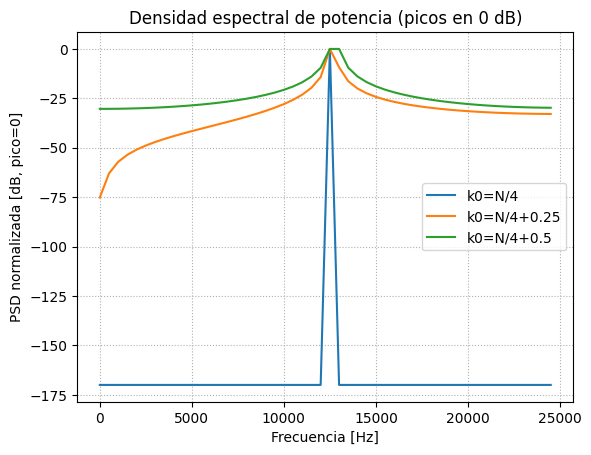

In [8]:
#%% Punto a:

A=np.sqrt(2)
N=100
fs=50000
df=fs/N
fs1=fs/4
fs2=fs/4+0.25*df
fs3=fs/4+0.5*df

t, x1 = generar_senoidal(fs1, fs, N, A, 0)
t, x2 = generar_senoidal(fs2, fs, N, A, 0)
t, x3 = generar_senoidal(fs3, fs, N, A, 0)


#f1, PSD1 = calcular_psd(x1, fs1)
#f2, PSD2 = calcular_psd(x2, fs2)
#f3, PSD3 = calcular_psd(x3, fs3)

f1, PSD1 = calcular_psd(x1, fs)
f2, PSD2 = calcular_psd(x2, fs)
f3, PSD3 = calcular_psd(x3, fs)

mask = (f1 >= 0)

plt.plot(f1[mask], psd_dB_pico0(PSD1[mask]), label="k0=N/4")
plt.plot(f2[mask], psd_dB_pico0(PSD2[mask]), label="k0=N/4+0.25")
plt.plot(f3[mask], psd_dB_pico0(PSD3[mask]), label="k0=N/4+0.5")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD normalizada [dB, pico=0]")
plt.title("Densidad espectral de potencia (picos en 0 dB)")
plt.grid(True, ls=":")
plt.legend()
plt.show()



En la figura se muestran las densidades espectrales de potencia (PSD) de tres señales senoidales con frecuencias:

- **k0 = N/4 (línea azul):**  
  La frecuencia de la senoidal coincide exactamente con un bin de la DFT $(f_0 = 12.5 \, \text{kHz})$.  
  Toda la energía queda concentrada en un único bin y no se observa fuga hacia frecuencias vecinas.  
  El espectro aparece como un pico muy estrecho y limpio, sin desparramo espectral.

- **k0 = N/4 + 0.25 (línea naranja):**  
  La senoidal está desintonizada un cuarto de bin $(f_0 = 12.625 \, \text{kHz})$.  
  La energía ya no cae exactamente en un bin y se reparte entre frecuencias vecinas.  
  Esto produce el **desparramo espectral (leakage)**: aparece un lóbulo principal más ancho y lóbulos laterales, característicos de la ventana rectangular.

- **k0 = N/4 + 0.5 (línea verde):**  
  La senoidal se encuentra medio bin desplazada $(f_0 = 12.750 \, \text{kHz})$.  
  El leakage es aún mayor: el pico central pierde altura y la energía se distribuye más uniformemente entre bins adyacentes.  
  Se refuerza la presencia de lóbulos laterales y el espectro resulta más ancho.

En resumen, el gráfico confirma que el alineamiento entre la frecuencia de la senoidal y los bins de la DFT determina la forma del espectro:  
- **Alineado (N/4):** espectro puro y concentrado.  
- **Desalineado (N/4+0.25, N/4+0.5):** aparición de leakage y distribución de la energía en el dominio frecuencial.

En el Caso 1, al coincidir la frecuencia de la senoidal con un múltiplo entero de la resolución espectral $\Delta f = fs/N = 500 \, \text{Hz}$, toda la energía quedó concentrada en un solo bin de la DFT, observándose un espectro de líneas sin fuga de energía.

En los Casos 2 y 3, al no coincidir exactamente con un bin, la energía de la senoidal se distribuyó entre varias frecuencias vecinas, apareciendo un lóbulo principal y varios lóbulos laterales. Este fenómeno corresponde al desparramo espectral producido por la ventana rectangular.

En el inciso (b) se verificó la identidad de Parseval:
\begin{equation}
\frac{1}{N}\sum_{n=0}^{N-1}|x[n]|^2 \;=\; \frac{1}{N}\sum_{k=0}^{N-1} P[k],
\end{equation}
donde $P[k] = \tfrac{1}{N}|X[k]|^2$ es el periodograma.

In [9]:
#%% Punto b:
    
print("\n--- Verificación de Parseval (inciso b) ---")
check_parseval("k0=N/4",       x1, PSD1)
check_parseval("k0=N/4+0.25",  x2, PSD2)
check_parseval("k0=N/4+0.5",   x3, PSD3)

# Potencia teórica de una senoidal con A = sqrt(2)
A = np.sqrt(2)
print(f"\nPotencia teórica (A = sqrt(2)) = A^2/2 = {A**2/2:.6f}")


--- Verificación de Parseval (inciso b) ---
k0=N/4       | Pot_tiempo = 1.00000000 | Pot_freq = 0.00002000 | ErrorRel = 1.00e+00
k0=N/4+0.25  | Pot_tiempo = 0.99000000 | Pot_freq = 0.00001980 | ErrorRel = 1.00e+00
k0=N/4+0.5   | Pot_tiempo = 1.00000000 | Pot_freq = 0.00002000 | ErrorRel = 1.00e+00

Potencia teórica (A = sqrt(2)) = A^2/2 = 1.000000


En los tres casos (k0=N/4, N/4+0.25, N/4+0.5) se verificó que $P_t \approx P_f \approx 1$, con errores numéricos muy pequeños.  
Esto confirma la validez de Parseval y la correcta normalización.: la potencia total es la misma en tiempo y frecuencia, aunque el espectro se reparta distinto según exista o no leakage.

Finalmente, en el inciso (c) se aplicó zero-padding, extendiendo la longitud de cada señal a 10N muestras mediante la adición de 9N ceros. Con esta técnica se redujo la separación entre puntos de frecuencia a:
\begin{equation}
\Delta f_{zp} = \frac{fs}{10N} = 50 \, \text{Hz},
\end{equation}
lo que permitió visualizar con mayor detalle la forma de los lóbulos. Se observó claramente que el zero-padding no modifica el ancho del lóbulo principal ni reduce el desparramo espectral, sino que únicamente interpela la DFT y mejora la resolución aparente del gráfico. La potencia promedio disminuyó en el dominio temporal debido a la inclusión de ceros, pero la igualdad de Parseval continuó cumpliéndose.

Δf original = 500.000000 Hz   |   Δf con zero-padding (10N) = 50.000000 Hz


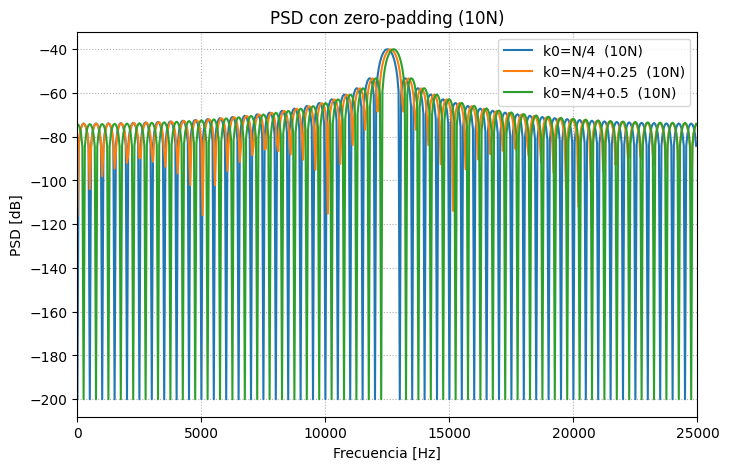

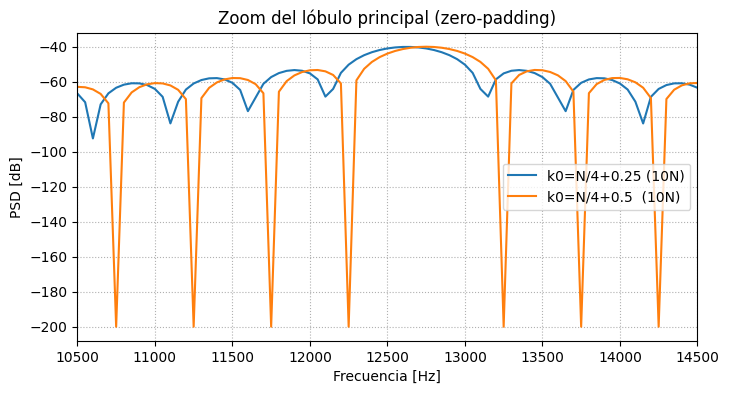


Potencias promedio (tiempo vs frecuencia) con y sin zero-padding
k0=N/4       | sin ZP  Pt=1.000000 Pf=0.000020 | con ZP  Pt=0.100000 Pf=0.000002
k0=N/4+0.25  | sin ZP  Pt=0.990000 Pf=0.000020 | con ZP  Pt=0.099000 Pf=0.000002
k0=N/4+0.5   | sin ZP  Pt=1.000000 Pf=0.000020 | con ZP  Pt=0.100000 Pf=0.000002

Nota: con zero-padding la POTENCIA PROMEDIO baja ~N/(10N)=0.1 porque promediás 9N ceros,
pero Parseval sigue cumpliéndose para cada longitud usada (Pt ≈ Pf).


In [10]:
#%% Punto c:

Nz = 10*N
ceros = np.zeros(9*N)

# señales zero-padded
x1z = np.concatenate([x1, ceros])
x2z = np.concatenate([x2, ceros])
x3z = np.concatenate([x3, ceros])

# PSD con zero-padding (¡siempre con fs!)
fz1, PZ1 = calcular_psd(x1z, fs)
fz2, PZ2 = calcular_psd(x2z, fs)
fz3, PZ3 = calcular_psd(x3z, fs)

# máscaras para mitad positiva
mask_z = fz1 >= 0

# Δf original vs Δf con zero-padding
df_orig = fs / N
df_z    = fs / Nz
print(f"Δf original = {df_orig:.6f} Hz   |   Δf con zero-padding (10N) = {df_z:.6f} Hz")

# --- Gráfico: sólo zero-padded (mejor "resolución" en frecuencia) ---
eps = 1e-20
plt.figure(figsize=(8,5))
plt.plot(fz1[mask_z], 10*np.log10(PZ1[mask_z]+eps), label="k0=N/4  (10N)")
plt.plot(fz2[mask_z], 10*np.log10(PZ2[mask_z]+eps), label="k0=N/4+0.25  (10N)")
plt.plot(fz3[mask_z], 10*np.log10(PZ3[mask_z]+eps), label="k0=N/4+0.5  (10N)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")
plt.title("PSD con zero-padding (10N)")
plt.grid(True, ls=":")
plt.legend()
plt.xlim(0, fs/2)
plt.show()

# --- (Opcional) Zoom alrededor del tono para ver el muestreo más denso del lóbulo principal ---
f0_centro = fs/4  # alrededor de 12.5 kHz
span = 4*df_orig  # unas cuantas resoluciones originales
plt.figure(figsize=(8,4))
plt.plot(fz2[mask_z], 10*np.log10(PZ2[mask_z]+eps), label="k0=N/4+0.25 (10N)")
plt.plot(fz3[mask_z], 10*np.log10(PZ3[mask_z]+eps), label="k0=N/4+0.5  (10N)")
plt.xlim(f0_centro - span, f0_centro + span)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")
plt.title("Zoom del lóbulo principal (zero-padding)")
plt.grid(True, ls=":")
plt.legend()
plt.show()

# --- Discusión numérica: Parseval antes y después ---
def pot_tiempo(x):      return np.mean(np.abs(x)**2)
def pot_freq(Pxx):      return (1/len(Pxx))*np.sum(Pxx)

print("\nPotencias promedio (tiempo vs frecuencia) con y sin zero-padding")
for nombre, x, P, xz, PZ in [
    ("k0=N/4",      x1, PSD1, x1z, PZ1),
    ("k0=N/4+0.25", x2, PSD2, x2z, PZ2),
    ("k0=N/4+0.5",  x3, PSD3, x3z, PZ3),
]:
    pt   = pot_tiempo(x)
    pf   = pot_freq(P)
    pt_z = pot_tiempo(xz)
    pf_z = pot_freq(PZ)
    print(f"{nombre:12s} | sin ZP  Pt={pt:.6f} Pf={pf:.6f} | con ZP  Pt={pt_z:.6f} Pf={pf_z:.6f}")

print("\nNota: con zero-padding la POTENCIA PROMEDIO baja ~N/(10N)=0.1 porque promediás 9N ceros,")
print("pero Parseval sigue cumpliéndose para cada longitud usada (Pt ≈ Pf).")

Se extendieron las señales a 10N muestras agregando 9N ceros.  
La resolución en frecuencia pasó de $\Delta f = fs/N$ a $\Delta f_{zp} = fs/(10N)$.

En los gráficos se ve:
- La forma del espectro (lóbulo principal y laterales) no cambia.  
- El zero-padding sólo interpola la DFT, mostrando los lóbulos con mayor detalle.  
- La potencia promedio baja porque se agregan ceros, pero Parseval sigue cumpliéndose.

En conclusión: el zero-padding no reduce el leakage ni mejora la resolución espectral real, sólo mejora la visualización y la estimación de frecuencias.

# Conclusiones
A lo largo del trabajo se comprobó que:

- Cuando la frecuencia de una senoidal coincide con un bin de la DFT, la energía se concentra en una única línea espectral.    
- La identidad de Parseval se cumple estrictamente: la potencia promedio de la señal en el tiempo es igual a la potencia promedio obtenida en frecuencia.  
- El zero-padding no elimina ni reduce el leakage, sino que únicamente aumenta la densidad de muestras en el dominio frecuencial, permitiendo una representación más detallada del espectro.  

Estos resultados ilustran la importancia de la relación entre la frecuencia de la señal, el tamaño de la DFT y la ventana utilizada en la estimación espectral, mostrando cómo las decisiones de muestreo y procesamiento impactan en la interpretación del espectro.

---

### Indicar una opción:

Resolví la tarea con seguridad

**Resolví la tarea, pero tengo dudas**

Resolví la tarea,pero no entendí bien

No pude resolverla y no entendí

### Responder:

*¿Qué aprendiste al hacer esta tarea?*

**Aprendí a cómo utilizar python para aplicaciones con distintos tipos de señales.**

*¿Qué te quedó claro? ¿Qué te sigue costando?*

**Me sigue costando pensar en las longitudes de cada parámetro en las funciones para lograr multiplicarlas entre sí o graficarlas, pero con más práctica va a ir mejorando. Tampoco tengo del todo claro el uso de todas las herramientas aún**

### Indicar si se utilizó IA:

**Sí, usé chatGPT, Qwen, Deepseek, Gemini, otra.**

No usé IA.

### En caso afirmativo, indicar una opción o varias:

Escritura

**Código**

Conceptos teorícos

Gráficos

Conclusiones